In [1]:
#!/usr/bin/env python
# coding: utf-8

import warnings
warnings.filterwarnings("ignore")

import env
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from split_scale import split_my_data, standard_scaler, scale_inverse, uniform_scaler, gaussian_scaler, min_max_scaler, iqr_robust_scaler

from wrangle import wrangle_telco

In [2]:
df = wrangle_telco()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1694
Data columns (total 4 columns):
customer_id        1685 non-null object
tenure             1685 non-null int64
monthly_charges    1685 non-null float64
total_charges      1685 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 65.8+ KB


In [4]:
print(df.columns[df.isnull().any()])

Index([], dtype='object')


In [5]:
df.monthly_charges.value_counts(sort=True, ascending=True)

df.describe()

,tenure,monthly_charges,total_charges
count,1685.00000,1685.000000,1685.000000
mean,57.07181,60.872374,3728.933947
std,17.72913,34.712210,2571.252806
min,1.00000,18.400000,20.350000
25%,48.00000,24.050000,1278.800000
50%,64.00000,64.450000,3623.950000
75%,71.00000,90.550000,5999.850000
max,72.00000,118.750000,8672.450000


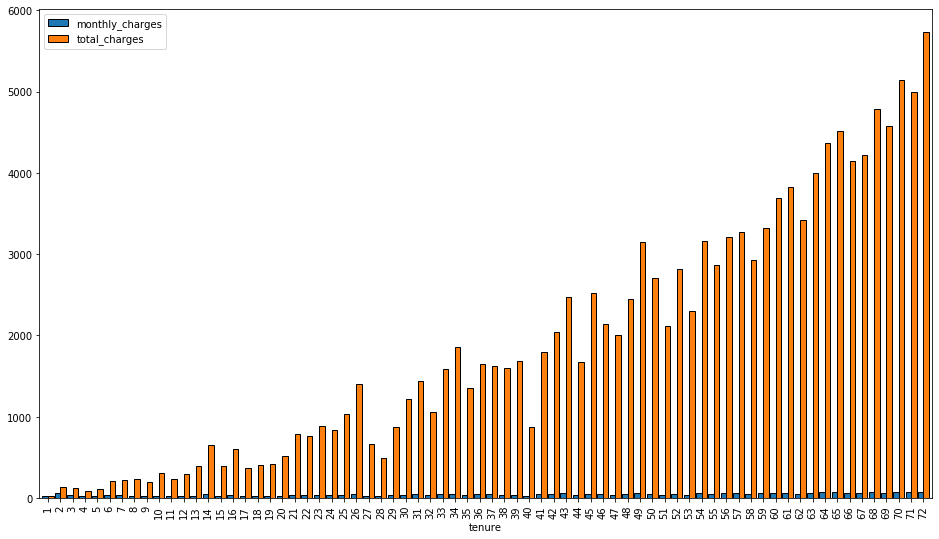

In [6]:
df.groupby('tenure').mean().plot.bar(figsize=(16,9), ec='black', width=.9)

col_names = ['customer_id', 'tenure', 'monthly_charges', 'total_charges']

X_train_scaled = df.copy()

X = df[['tenure', 'monthly_charges']]
y = df[['total_charges']]
train_pct = .25
X_train, X_test, y_train, y_test = split_my_data(X, y, train_pct)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

## Standard Scaler
# $$x'={\frac {x-{\bar {x}}}{\sigma }}$$

In [7]:
X_train_standard_scaled, X_test_standard_scaled, standard_scaler = standard_scaler(X_train, X_test)

X_train_standard_scaled, X_test_standard_scaled

X_train_standard_scaled.head()

,tenure,monthly_charges
1357,0.274669,-0.654132
464,0.388652,0.205725
148,-2.517915,-1.205657
87,-1.150118,0.046492
1201,0.844584,1.357991


## Standard Scale Inverse

In [8]:
X_train_standard_unscaled, X_test_standard_unscaled = scale_inverse(X_train_standard_scaled, X_test_standard_scaled, standard_scaler)


X_train_standard_unscaled.head()

,tenure,monthly_charges
1357,62.0,38.60
464,64.0,68.30
148,13.0,19.55
87,37.0,62.80
1201,72.0,108.10


## Uniform Scaler
 
 - It smooths out unusual distributions, and it spreads out the most frequent values and reduces the impact of (marginal) outliers →∴ a robust preprocessing scheme.
 
 - It does distort correlations and distances within and across features.

In [9]:
X_train_uniform_scaled, X_test_uniform_scaled, uniform_scaler = uniform_scaler(X_train, X_test)
X_train_uniform_scaled.head()

,tenure,monthly_charges
1357,0.439394,0.382100
464,0.489899,0.526360
148,0.035354,0.050505
87,0.149747,0.483409
1201,1.000000,0.888625


## Uniform Scale Inverse

In [10]:
X_train_uniform_unscaled, X_test_uniform_unscaled = scale_inverse(X_train_uniform_scaled, X_test_uniform_scaled, uniform_scaler)
X_train_uniform_unscaled.head()

,tenure,monthly_charges
1357,62.0,38.60
464,64.0,68.30
148,13.0,19.55
87,37.0,62.80
1201,72.0,108.10


## Gaussian Scaler
### Yeo-Johnson
 - supports both positive or negative data
 $$\begin{split}x_i^{(\lambda)} =
 \begin{cases}
  [(x_i + 1)^\lambda - 1] / \lambda & \text{if } \lambda \neq 0, x_i \geq 0, \\[8pt]
 \ln{(x_i) + 1} & \text{if } \lambda = 0, x_i \geq 0 \\[8pt]
 -[(-x_i + 1)^{2 - \lambda} - 1] / (2 - \lambda) & \text{if } \lambda \neq 2, x_i < 0, \\[8pt]
  - \ln (- x_i + 1) & \text{if } \lambda = 2, x_i < 0
 \end{cases}\end{split}$$

### Box-Cox
- only supports positive data
 $$\begin{split}x_i^{(\lambda)} =
 \begin{cases}
 \dfrac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\[8pt]
 \ln{(x_i)} & \text{if } \lambda = 0,
 \end{cases}\end{split}$$

In [11]:
X_train_gaussian_scaled, X_test_gaussian_scaled, gaussian_scaler = gaussian_scaler(X_train, X_test)
X_train_gaussian_scaled.head()

,tenure,monthly_charges
1357,8503.953357,8.664501
464,9164.848991,11.553990
148,231.529618,6.028984
87,2533.937505,11.083739
1201,12101.693317,14.442111


## Gaussian Scale Inverse

In [12]:
X_train_gaussian_unscaled, X_test_gaussian_unscaled = scale_inverse(X_train_gaussian_scaled, X_test_gaussian_scaled, gaussian_scaler)
X_train_gaussian_unscaled.head()

,tenure,monthly_charges
1357,62.0,38.60
464,64.0,68.30
148,13.0,19.55
87,37.0,62.80
1201,72.0,108.10


## Min-Max Scaler


$$x' = {\frac {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}$$ 
$$x' = a+{\frac  {x-{\text{min}}(x))(b-a)}{{\text{max}}(x)-{\text{min}}(x)}}$$

In [13]:
X_train_min_max_scaled, X_test_min_max_scaled, min_max_scaler = min_max_scaler(X_train, X_test)
X_train_min_max_scaled.head()

,tenure,monthly_charges
1357,0.859155,0.200300
464,0.887324,0.497003
148,0.169014,0.009990
87,0.507042,0.442058
1201,1.000000,0.894605


## Min-Max Scale Inverse

In [14]:
X_train_min_max_unscaled, X_test_min_max_unscaled = scale_inverse(X_train_min_max_scaled, X_test_min_max_scaled, min_max_scaler)
X_train_min_max_unscaled.head()

,tenure,monthly_charges
1357,62.0,38.60
464,64.0,68.30
148,13.0,19.55
87,37.0,62.80
1201,72.0,108.10


## IRQ Robust Scaler
- With a lot of outliers, scaling using the mean and variance is not going to work very well.
 
- Using RobustScaler, the median is removed (instead of mean) and data is scaled according to a quantile range (the IQR is default)

In [15]:
X_train_iqr_robust_scaled, X_test_iqr_robust_scaled, iqr_robust_scaler = iqr_robust_scaler(X_train, X_test)
X_train_iqr_robust_scaled.head()

,tenure,monthly_charges
1357,-0.090909,-0.394717
464,0.000000,0.053585
148,-2.318182,-0.682264
87,-1.227273,-0.029434
1201,0.363636,0.654340


## IRQ Robust Scale Inverse

In [16]:
X_train_iqr_robust_unscaled, X_test_iqr_robust_unscaled = scale_inverse(X_train_iqr_robust_scaled, X_test_iqr_robust_scaled, iqr_robust_scaler)
X_train_iqr_robust_unscaled.head()

,tenure,monthly_charges
1357,62.0,38.60
464,64.0,68.30
148,13.0,19.55
87,37.0,62.80
1201,72.0,108.10
